### Demo ELLA analysis

Code for "A Complete Demo": https://jadexq.github.io/ELLA/complete_demo.html

In [1]:
# import ELLA
from ELLA.ELLA import model_beta, model_null, loss_ll, ELLA
ella_demo = ELLA(dataset='demo')

#### Data pre-processing

In [2]:
# load data
ella_demo.load_data(data_path='input/complete_demo_data.pkl')

Number of cell types 1
Average number of genes 50.0
Average number of cells 20.0
Number of default kernels 22


In [3]:
# register cells
ella_demo.register_cells()

Processing cells: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.41it/s]

Number of cells registered 20


In [4]:
# prepare data for model fitting
ella_demo.nhpp_prepare() 

Preparing data for fibroblast: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 56.03it/s]


#### Model fitting

In [5]:
# fit nhpp model
# ella_demo.nhpp_fit()

# load saved results
ella_demo.load_nhpp_fit_results(res_path='output/nhpp_fit_results_saved.pkl')

#### Testing and estimation

In [6]:
# expression intensity estimation
ella_demo.weighted_density_est()

In [7]:
# likelihood ratio test
ella_demo.compute_pv()

Number of kernels in use 22
fibroblast #sig=48


#### Pattern clustering

The max number of clusters K=10


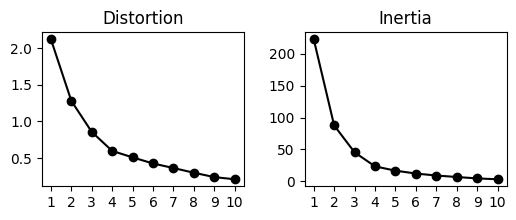

In [8]:
ella_demo.pattern_clustering()

Pattern 1: 6 genes
Pattern 2: 14 genes
Pattern 3: 11 genes
Pattern 4: 8 genes
Pattern 5: 9 genes


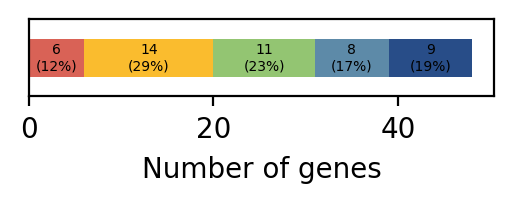

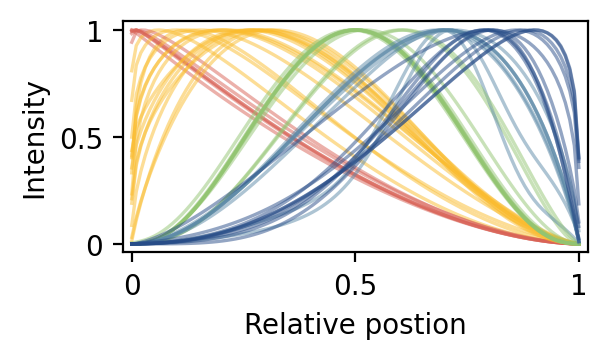

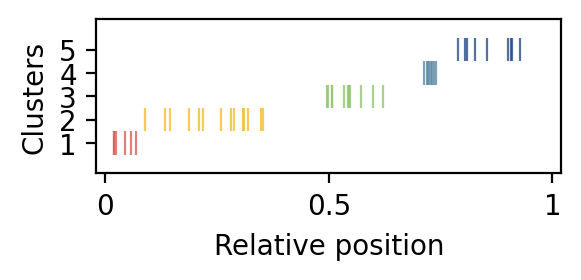

In [9]:
ella_demo.pattern_labeling(K=5)

#### Check out ELLA's results

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alphashape

red = '#c0362c'
lightorange = '#fabc2e'
lightgreen = '#93c572'
lightblue = '#5d8aa8'
darkgray ='#545454'
darkblue = '#284d88'
colors = [red, lightorange, lightgreen, lightblue, darkblue]

In [11]:
# cell IDs
cells = ella_demo.cell_list_dict['fibroblast']
# gene IDs
genes = ella_demo.gene_list_dict['fibroblast']
# FDR corrected p values
pv = ella_demo.pv_fdr_tl['fibroblast']
# estimated expression intensities
lam = ella_demo.weighted_lam_est['fibroblast']
# pattern cluster label
lab = ella_demo.labels_dict['fibroblast']
# demo data
demo_data = pd.read_pickle('input/complete_demo_data.pkl')
# cell segmentations
cell_seg = demo_data['cell_seg']
# nucleus segmentations
nucleus_seg = demo_data['nucleus_seg']
# gene expressions
expr = demo_data['expr']

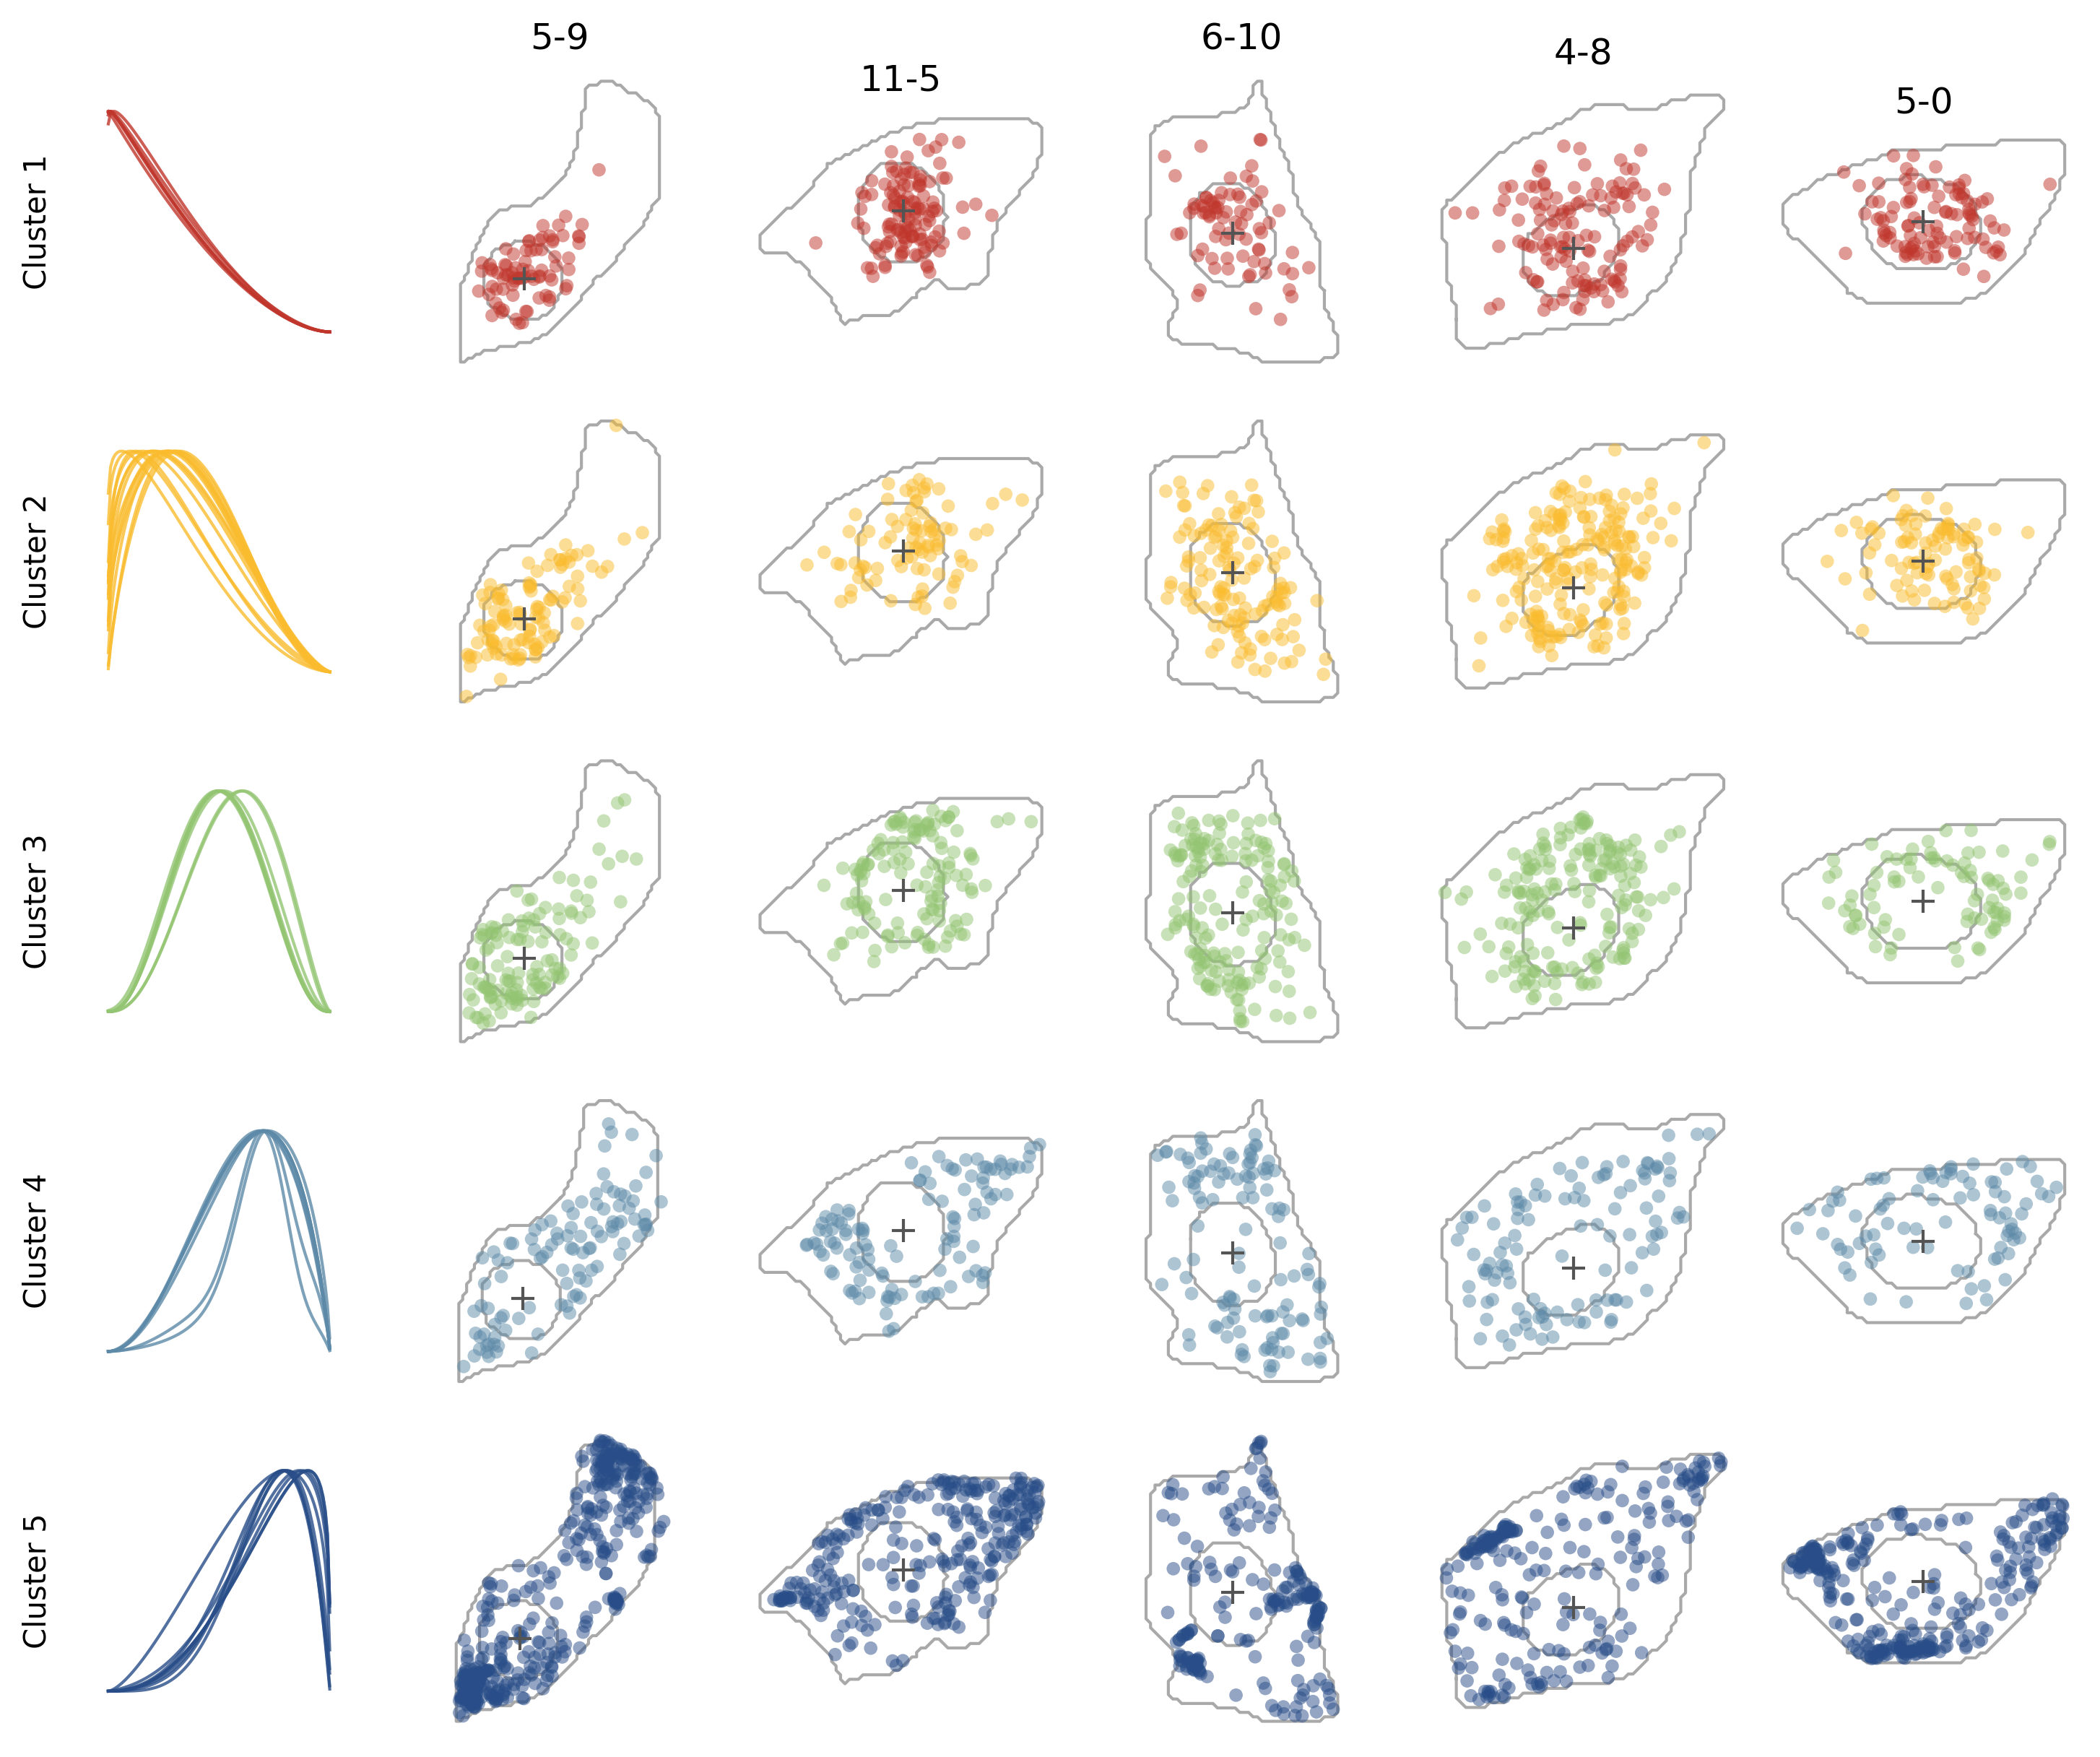

In [12]:
# plot cells and genes
cl_plot= ['5-9', '11-5', '6-10', '4-8', '5-0']
K = 5

nr = K
nc = len(cl_plot)+1
ss_nr = 2
ss_nc = 2
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr, nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.1, hspace=0.1)

# plot estimated expression intensities 
for k in range(K):
    ax = plt.subplot(gs[k,0])
    lams_k = np.array(lam)[lab==k,:]
    for j in range(lams_k.shape[0]):
        lam_g = lams_k[j,:]
        lam_g_std = (lam_g-np.min(lam_g))/(np.max(lam_g)-np.min(lam_g))
        ax.plot(np.linspace(0,1,len(lam_g_std)), lam_g_std, lw=1, alpha=0.8, color=colors[k])
    ax.set_xlim((-0.2, 1.2))
    ax.set_ylim((-0.2, 1.2))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel(f'Cluster {k+1}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# plot cells and genes
for i, c in enumerate(cl_plot):
    for k in range(K):
        ax = plt.subplot(gs[k,i+1])
        gl = np.array(genes)[lab==k]
        cell_seg_c = cell_seg[cell_seg.cell==c]
        nucleus_seg_c = nucleus_seg[nucleus_seg.cell==c]
        expr_c = expr[expr.cell==c]

        # cell segmentation
        x_reduced = (cell_seg_c.x.values//10) * 10 # reduce resolution to speedup alphashape
        y_reduced = (cell_seg_c.y.values//10) * 10
        points = np.stack((x_reduced, y_reduced)).transpose()
        unique_points = np.unique(points, axis=0)
        alpha_shape_ = alphashape.alphashape(unique_points, 0.1)
        cb_x_, cb_y_ = alpha_shape_.exterior.xy
        ax.plot(cb_x_, cb_y_, 
                alpha=0.5,
                color=darkgray, lw=1, zorder=1)

        # nuclear segmentation
        x_reduced = (nucleus_seg_c.x.values//10) * 10 # reduce res to speedup alphashape
        y_reduced = (nucleus_seg_c.y.values//10) * 10
        points = np.stack((x_reduced, y_reduced)).transpose()
        unique_points = np.unique(points, axis=0)
        alpha_shape_ = alphashape.alphashape(unique_points, 0.1)
        cb_x_, cb_y_ = alpha_shape_.exterior.xy
        ax.plot(cb_x_, cb_y_, 
                alpha=0.5,
                color=darkgray, lw=1, zorder=1)

        # gene expr
        expr_c_g = expr_c[expr_c.gene.isin(gl)]
        ax.scatter(expr_c_g.x,
                   expr_c_g.y,
                   s = 20,
                   edgecolor='none',
                   color=colors[k],
                   alpha=0.5,
                   zorder=2)

        # cell center
        xc = expr_c.centerX.iloc[0]
        yc = expr_c.centerY.iloc[0]
        ax.scatter(xc, yc, c=darkgray, marker='+',lw=1, s=60, zorder=3)

        ax.set_aspect('equal', adjustable='box')
        #ax.axis('off')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if k==0:
            ax.set_title(c)